首先通过GPS获取所在的经纬度。笔者所在地为杭州富阳，对应的经纬度为：

```R
lat <- 30 + 2 / 60 + 38 / 3600
lon <- 119 + 54 / 60 + 43 / 3600
```

In [34]:
suppressMessages({
  library(Ipaper)
  library(data.table)
  library(missInfo)
  library(terra)
  library(sf2)

  library(dplyr)
  library(ggplot2)
  library(lubridate)
})

arc_china = vect("/mnt/i/GitHub/shapefiles/China/bou1_4l_south_sml.shp")

# https://stackoverflow.com/questions/42729049/how-to-change-the-size-of-r-plots-in-jupyter
set_jupyter <- function(width = 10, height = 6, res = 200) {
  options(repr.plot.width = width, repr.plot.height = height, repr.plot.res = res)
}
set_jupyter(10, 6, 200)


Warning message:
“[readValues] raster has no values
”


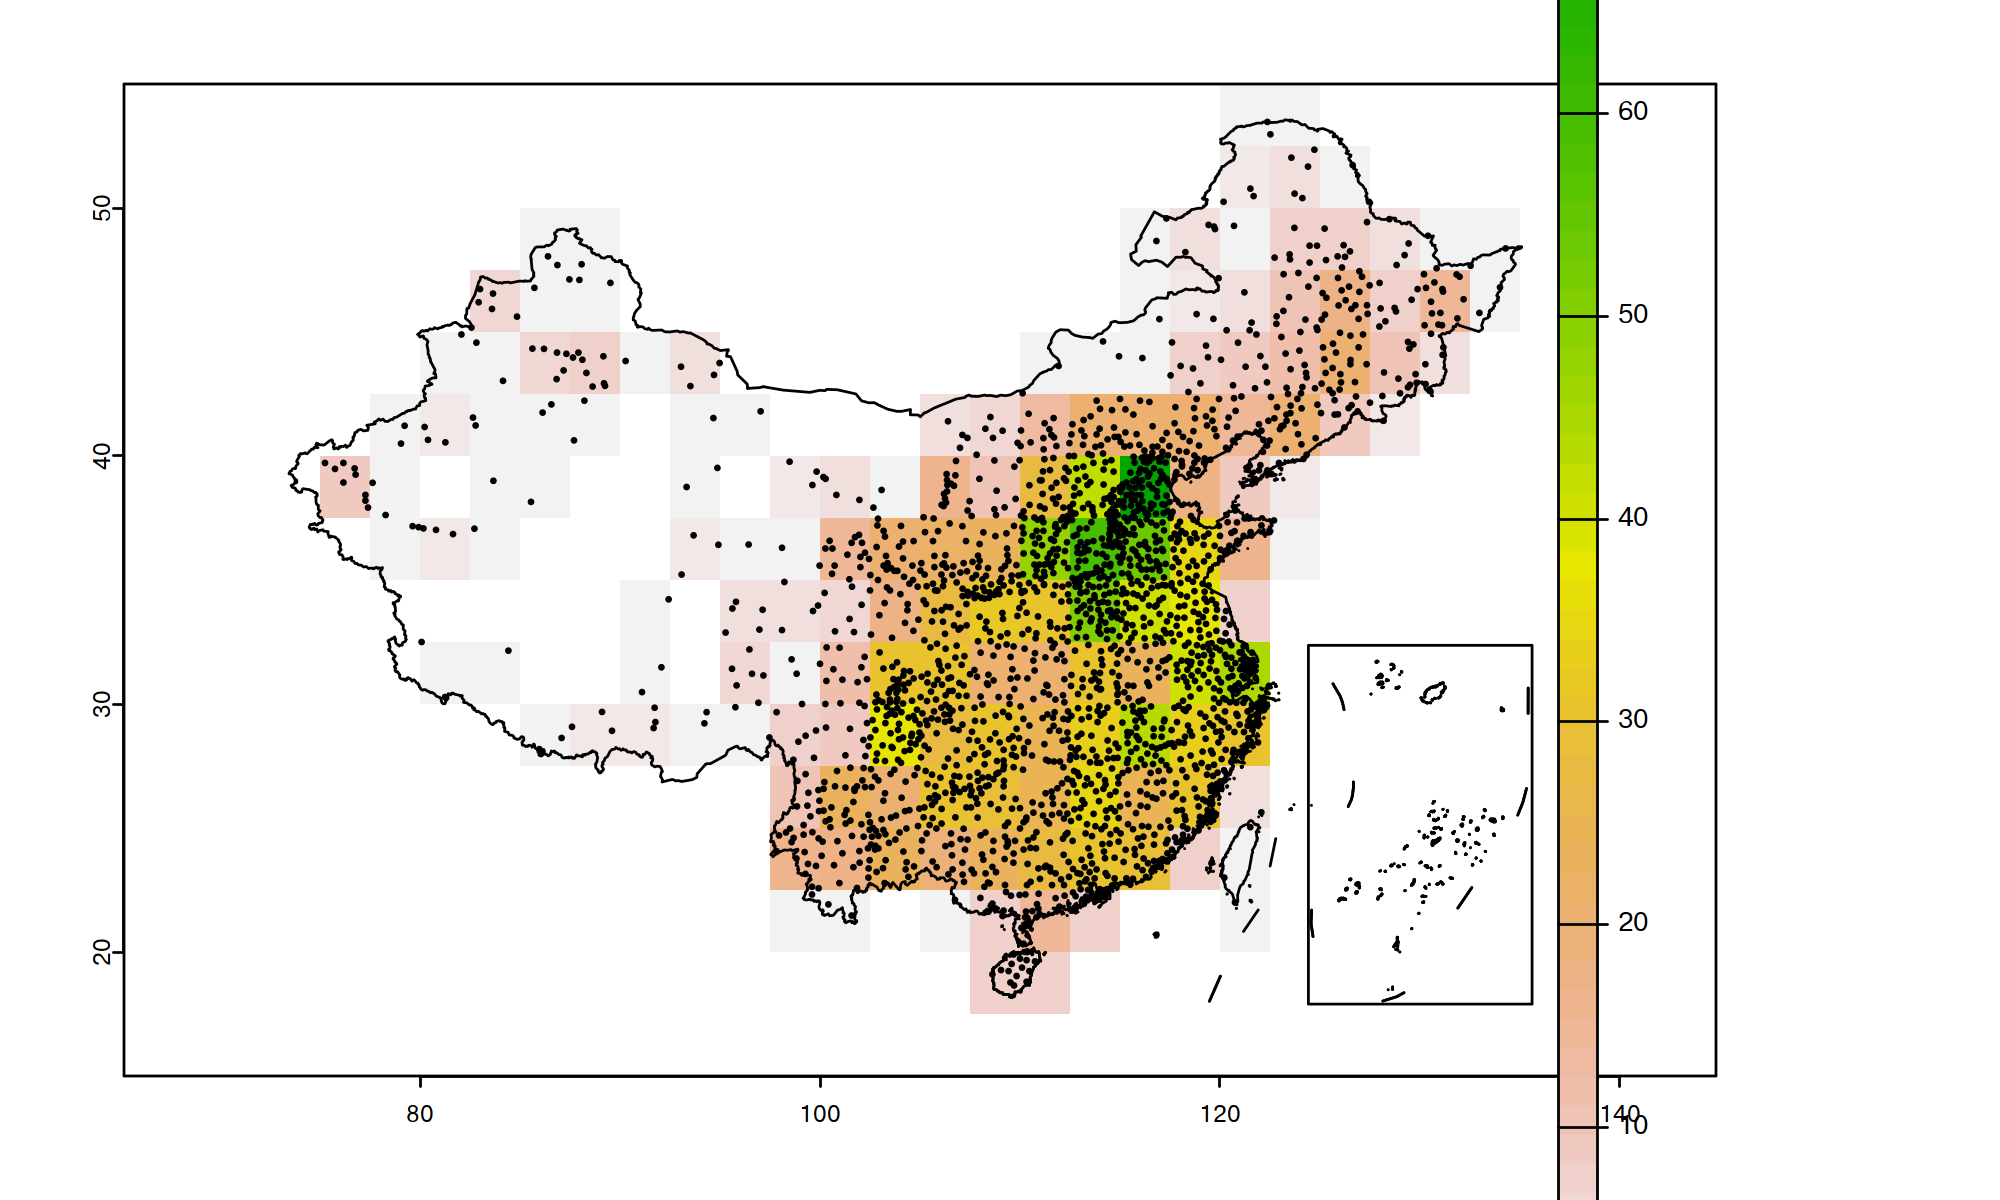

In [61]:
## 看一下全国气象站点的密度
st = st_met2176_hourly[lat > 0] # 去掉南极的站点
sp = vect(st) # data.frame to vect

r <- make_rast(range = c(70, 140, 15, 55), cellsize = 2.5)
values(r) %<>% seq_along(.)
names(r) <- "gridId"

## 计算站点密度
cal_sp_density <- function(sp, r = NUsLL) {
  d_grid <- as.data.frame(r, xy = TRUE) %>% as.data.table()
  x <- extract(r, sp) %>% as.data.table()
  data <- x[, .N, gridId] %>% merge(d_grid)
  r2 <- rast(data[, .(x, y, N)], type = "xyz")
  r2
}

r2 <- cal_sp_density(sp, r)
plot(r2, ylim=c(15, 55))
plot(sp, add=TRUE, cex=0.3)
plot(arc_china, add=TRUE)

In [36]:
lat <- 30 + 2 / 60 + 38 / 3600
lon <- 119 + 54 / 60 + 43 / 3600

p1 <- c(lon, lat) %>% t() # as row vector

## 查找附近的气象站


dist <- rdist.earth(st[, .(lon, lat)] %>% as.matrix(), p1)[, 1]
st %>% cbind(dist) %>%
  .[dist <= 50, ] %>% 
  .[order(dist)] %>% 
  reorder_name(c("site", "name", "prov", "dist"))

# 可见，距离最近的站点为富阳站，在东北方向，距离3.7km；因此下文选择富阳站，进行数据分析
p0 <- sp[sp$name == "富阳"]

site,name,prov,dist,lat,lon,alt,alt_obs,V02301,provcode
<int>,<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
58449,富阳,浙江,3.729743,30.05,119.95,46.5,47.9,013,330000
58448,临安,浙江,28.298101,30.22,119.70,117.6,118.6,012,330000
58457,杭州,浙江,32.349826,30.23,120.17,41.7,42.6,011,330000
58542,桐庐,浙江,33.495370,29.82,119.68,46.1,47.3,013,330000
58459,萧山,浙江,38.546885,30.18,120.28,44.3,42.4,013,330000


 class       : SpatVector 
 geometry    : points 
 dimensions  : 28, 7  (geometries, attributes)
 extent      : 118.98, 120.9, 29.05, 31.02  (xmin, xmax, ymin, ymax)
 coord. ref. :  
 names       :  site  name  prov   alt alt_obs V02301 provcode
 type        : <int> <chr> <chr> <num>   <num>  <chr>    <chr>
 values      : 58443  长兴  浙江    25    19.8    013   330000
               58446  安吉  浙江  72.2    66.8    013   330000
               58448  临安  浙江 117.6   118.6    012   330000

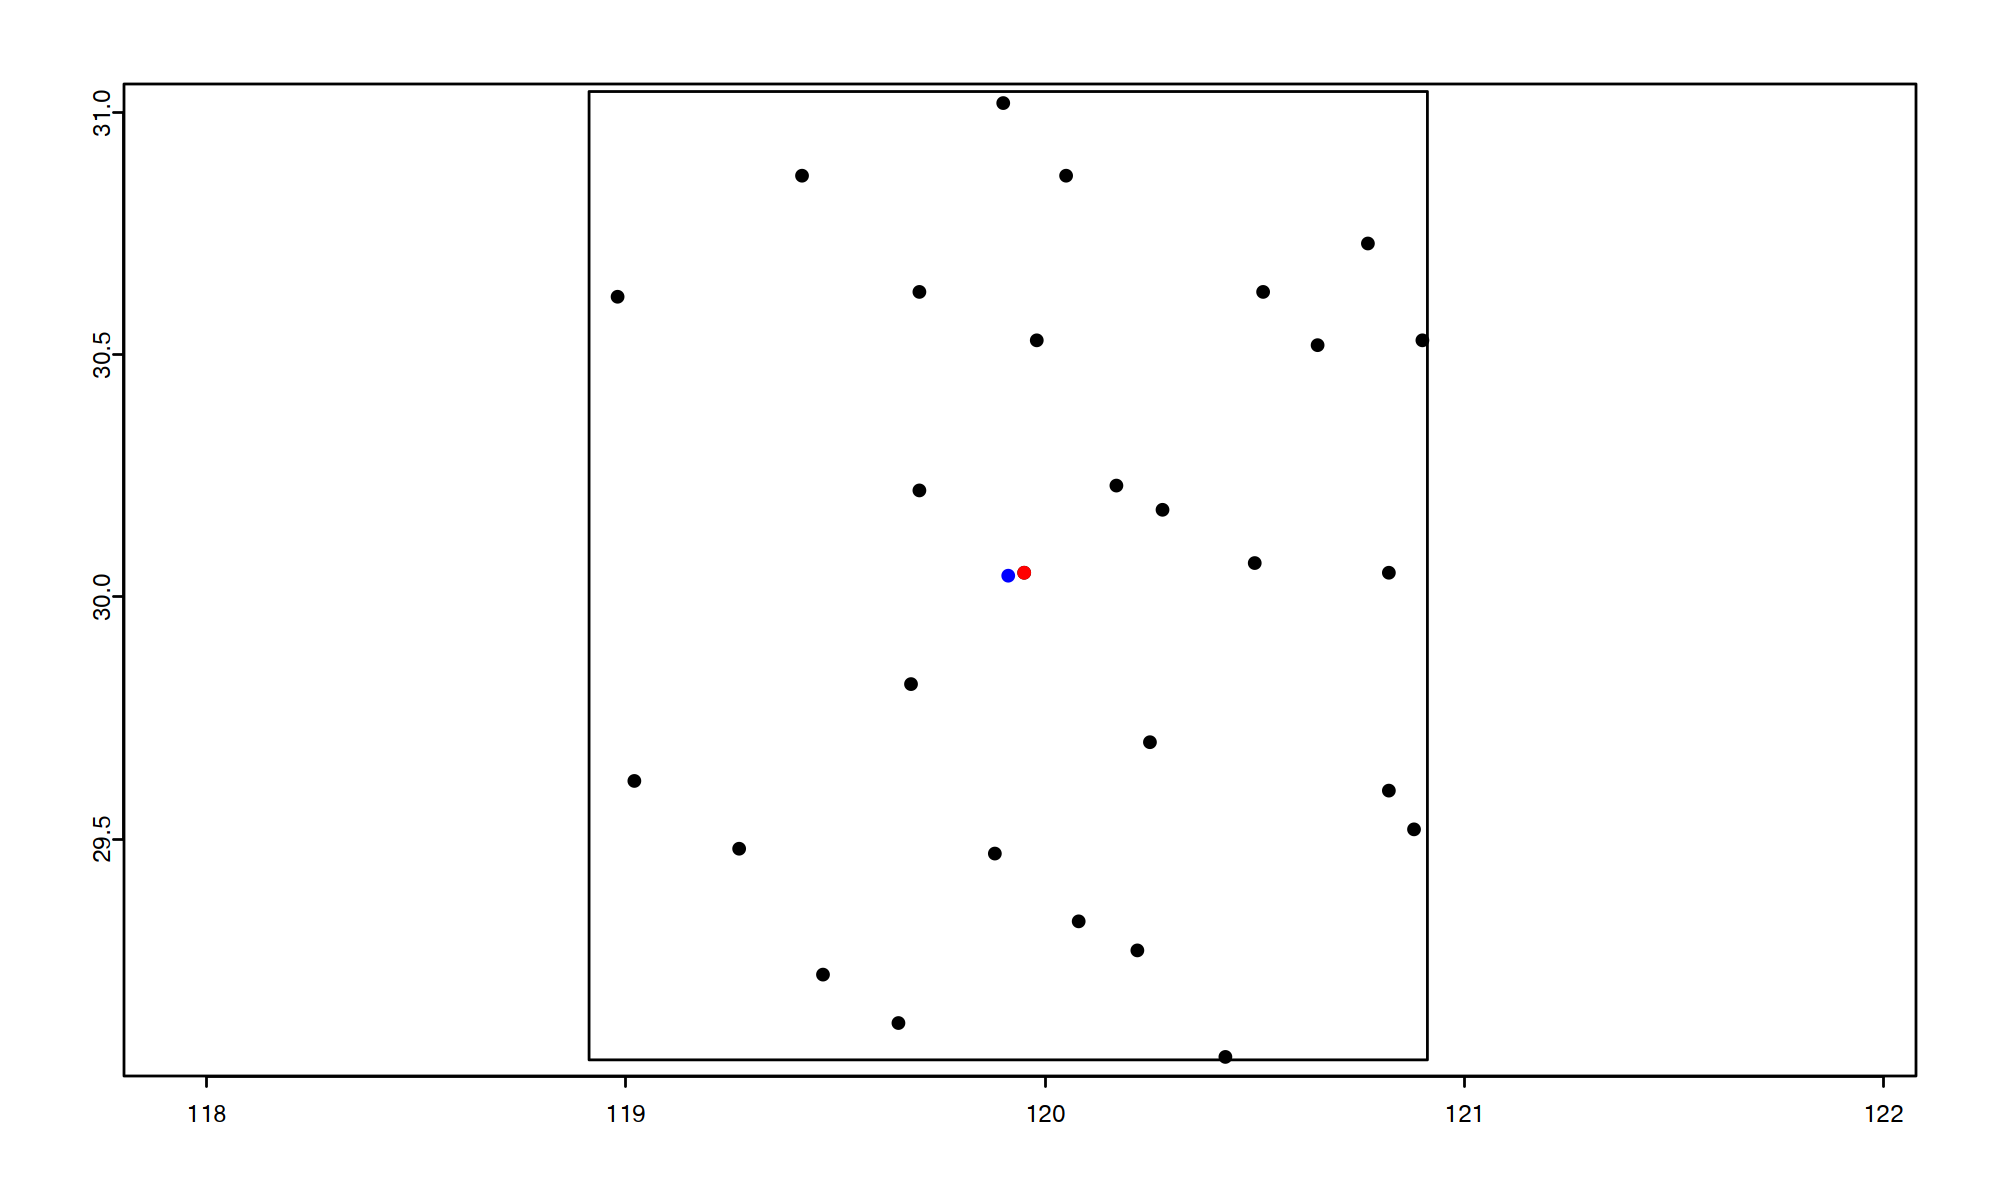

In [44]:
## 做一个buffer，看看1°范围内，有多少气象站
sp_me = data.frame(lon, lat) %>% vect()

## my loc:
delta = 1
e = c(lon + c(-1, 1) * delta, lat + c(-1, 1) * delta)
poly = st_rect(e) %>% vect()

## site density in 5deg grid
sp_buffer = terra::intersect(sp, poly)
sp_buffer

## 可见，2.5°范围内有153个气象站；1°范围内有28个站点
plot(sp_buffer)
plot(sp_me, col = "blue", add=TRUE)
plot(poly, add=TRUE)
plot(p0, border = "red", col = "red", add = TRUE)
# plot(arc_china, add = TRUE)


## 加载数据

In [18]:
df = fread("mete2000_[2022010100,2022071113].csv")
head(df)

date,Station_Id_C,WIN_S_Max,RHU_Min,WIN_D_INST_Max,WIN_S_Inst_Max,windpower,WIN_D_Avg_2mi,PRS_Max,tigan,WIN_D_S_Max,PRS,TEM_Max,WIN_S_Avg_2mi,PRS_Min,PRE_1h,TEM_Min,PRS_Sea,TEM,RHU
<dttm>,<int>,<dbl>,<int>,<int>,<dbl>,<int>,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
2022-01-01,50136,1.0,73,248,1.5,1,263,967.0,-34.13,253,966.6,-29.2,1.1,966.6,0,-29.8,1028.3,-29.2,74
2022-01-01,50137,1.2,71,121,2.4,1,147,986.7,-34.73,122,986.3,-29.7,0.8,986.3,0,-30.2,1028.6,-29.7,72
2022-01-01,50246,2.1,70,241,3.0,1,264,978.8,-36.96,280,978.4,-31.7,1.3,978.4,0,-32.5,1029.8,-31.7,71
2022-01-01,50247,0.6,72,179,0.9,1,142,958.5,-36.27,187,958.1,-31.1,0.5,958.1,0,-32.2,1030.5,-31.1,72
2022-01-01,50349,0.7,70,129,1.2,1,125,960.7,-37.84,137,960.4,-32.5,1.0,960.4,0,-33.1,1031.2,-32.5,71
2022-01-01,50353,3.1,67,205,3.3,2,199,1005.7,-42.07,207,1005.5,-36.3,2.1,1005.5,0,-37.9,1031.0,-36.3,69


In [50]:
## 变量信息
met2176_hourly_variables

name,longname,unit
<chr>,<chr>,<chr>
PRS,气压,hPa
PRS_Sea,海平面气压,hPa
PRS_Max,最高气压,hPa
PRS_Min,最低气压,hPa
TEM,温度/气温,degC
TEM_Max,最高气温,degC
TEM_Min,最低气温,degC
RHU,相对湿度,%
RHU_Min,最小相对湿度,%


In [45]:
library(hydroTools)
# , WIN_S_Max，居家风速不是应该体感温度的主要因素
site0 = st[name == "富阳", site]

d <- df[Station_Id_C == site0, ] %>%
  select(-2, -starts_with("WIN_D"), -ends_with("Min")) %>%
  .[, .(date, Tair = TEM, RH = RHU, tigan, prcp = PRE_1h, Pa = PRS / 10)] %>%
  mutate(date = date + dhours(8), q = RH2q(RH, Pa, Tair)) %>%
  reorder_name(c("date", "Tair", "RH", "q"))
head(d)

date,Tair,RH,q,tigan,prcp,Pa
<dttm>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
2022-01-01 08:00:00,4.6,66,0.003407681,2.84,0,102.40
2022-01-01 09:00:00,5.0,68,0.003610616,3.33,0,102.41
2022-01-01 10:00:00,5.6,65,0.003598193,3.91,0,102.42
2022-01-01 11:00:00,5.9,64,0.003619865,4.22,0,102.35
2022-01-01 12:00:00,6.3,63,0.003667685,4.63,0,102.23
2022-01-01 13:00:00,6.7,61,0.003653740,5.02,0,102.14


Warning message in melt.data.table(d, "date"):
“'measure.vars' [Tair, RH, q, tigan, ...] are not all of the same type. By order of hierarchy, the molten data value column will be of type 'double'. All measure variables not of type 'double' will be coerced too. Check DETAILS in ?melt.data.table for more on coercion.”


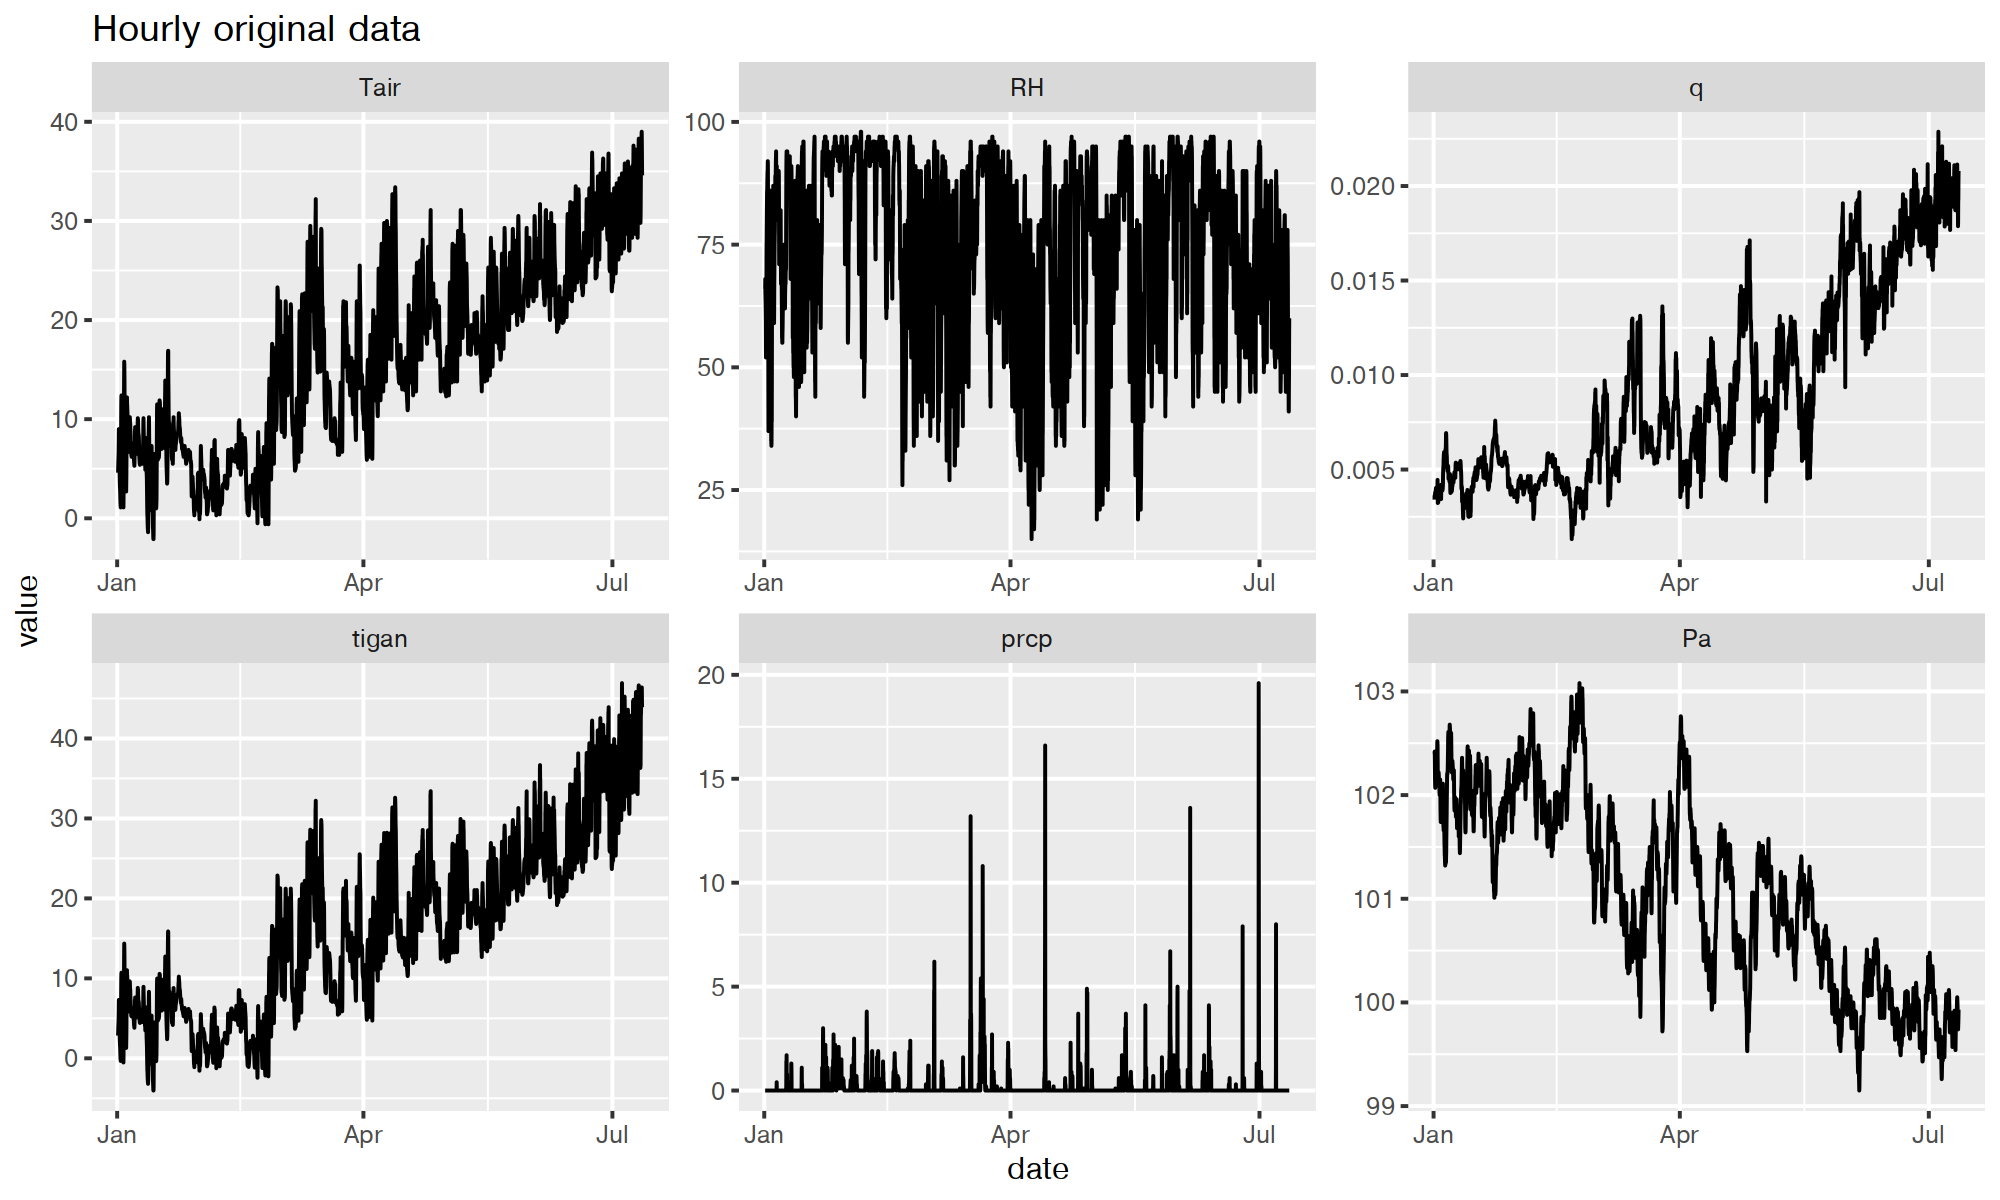

In [46]:
# hourly 原始数据
dat <- melt(d, "date")
ggplot(dat, aes(date, value)) +
  geom_line() +
  facet_wrap(~variable, scales = "free") + 
  ggtitle("Hourly original data")

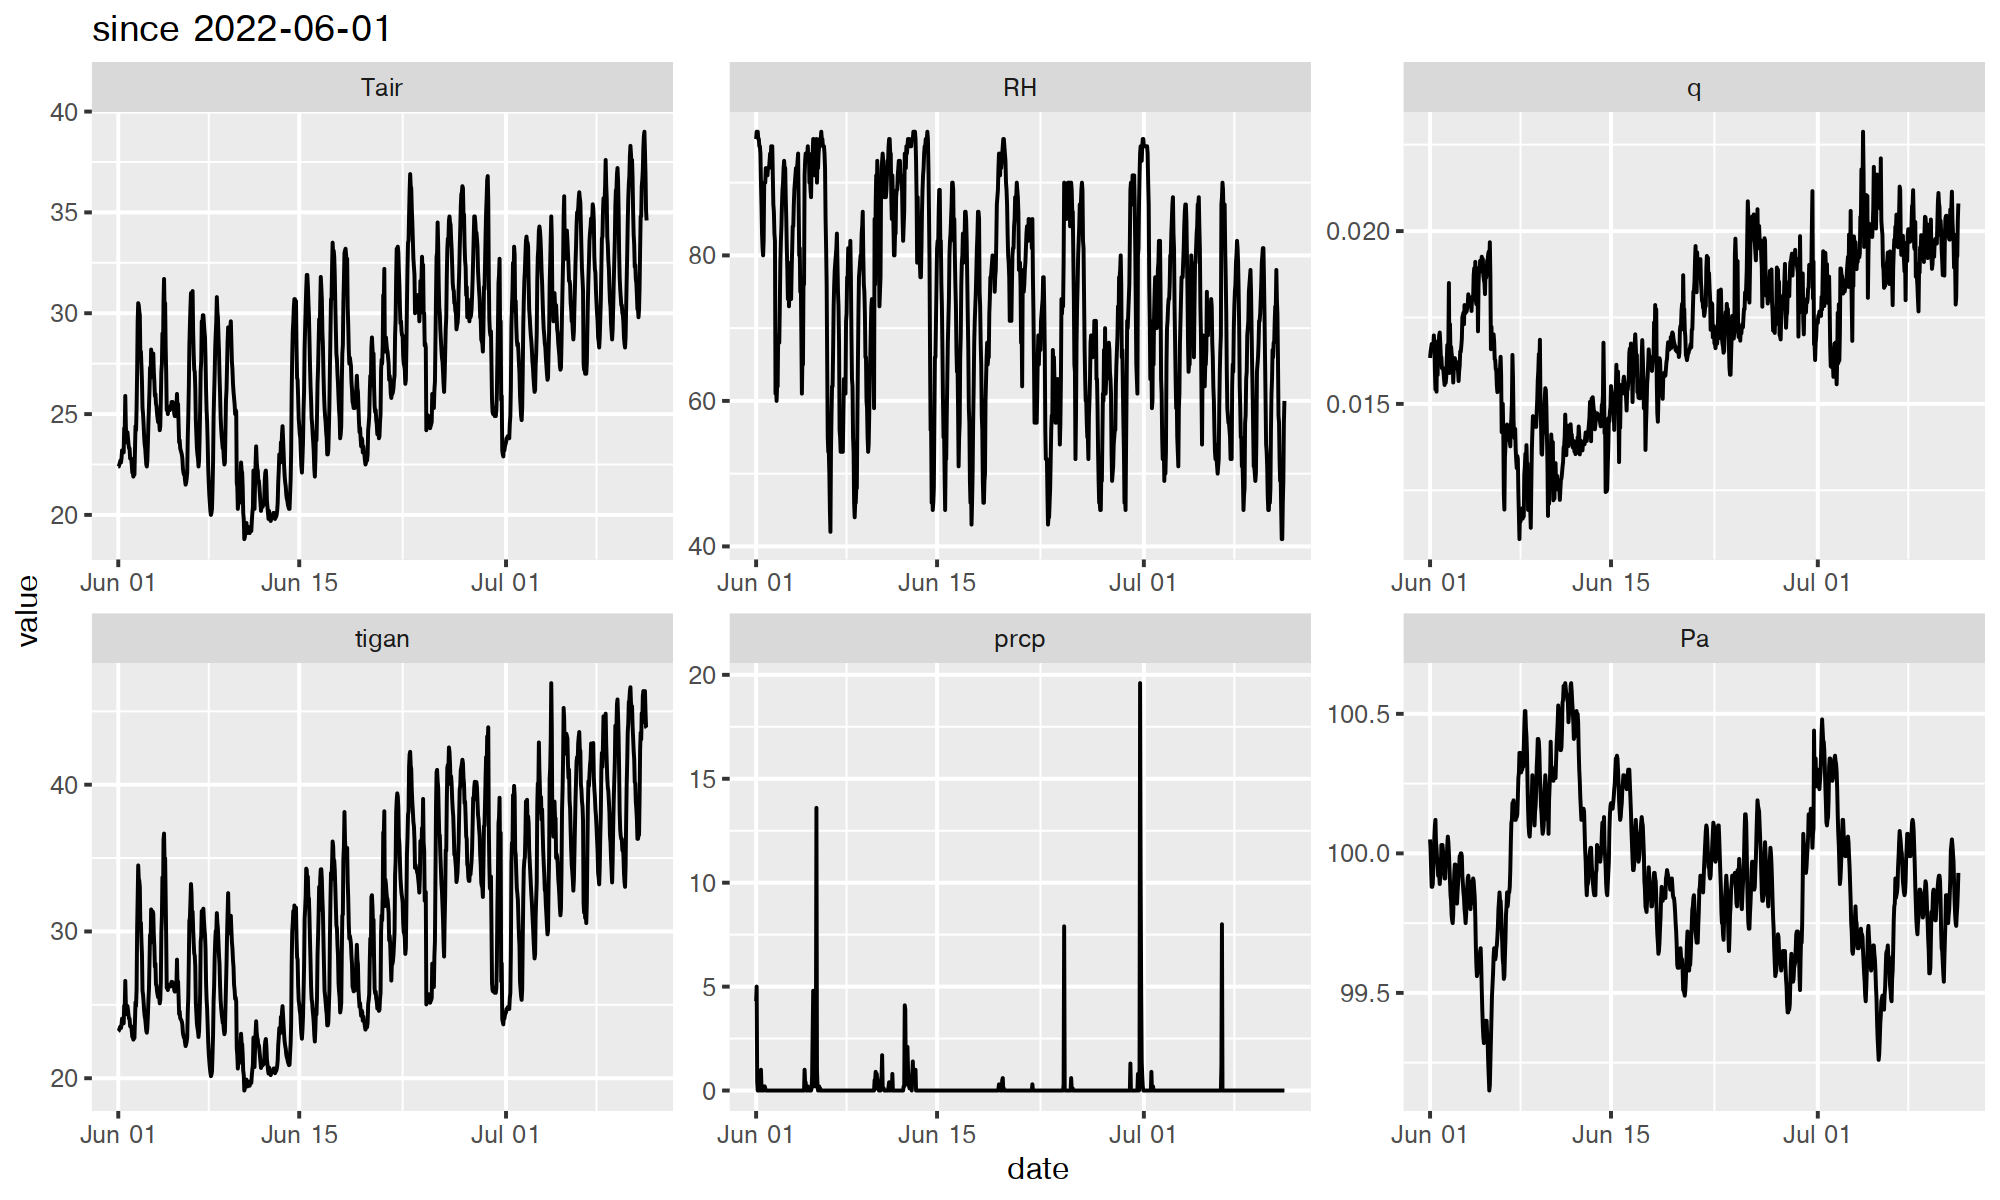

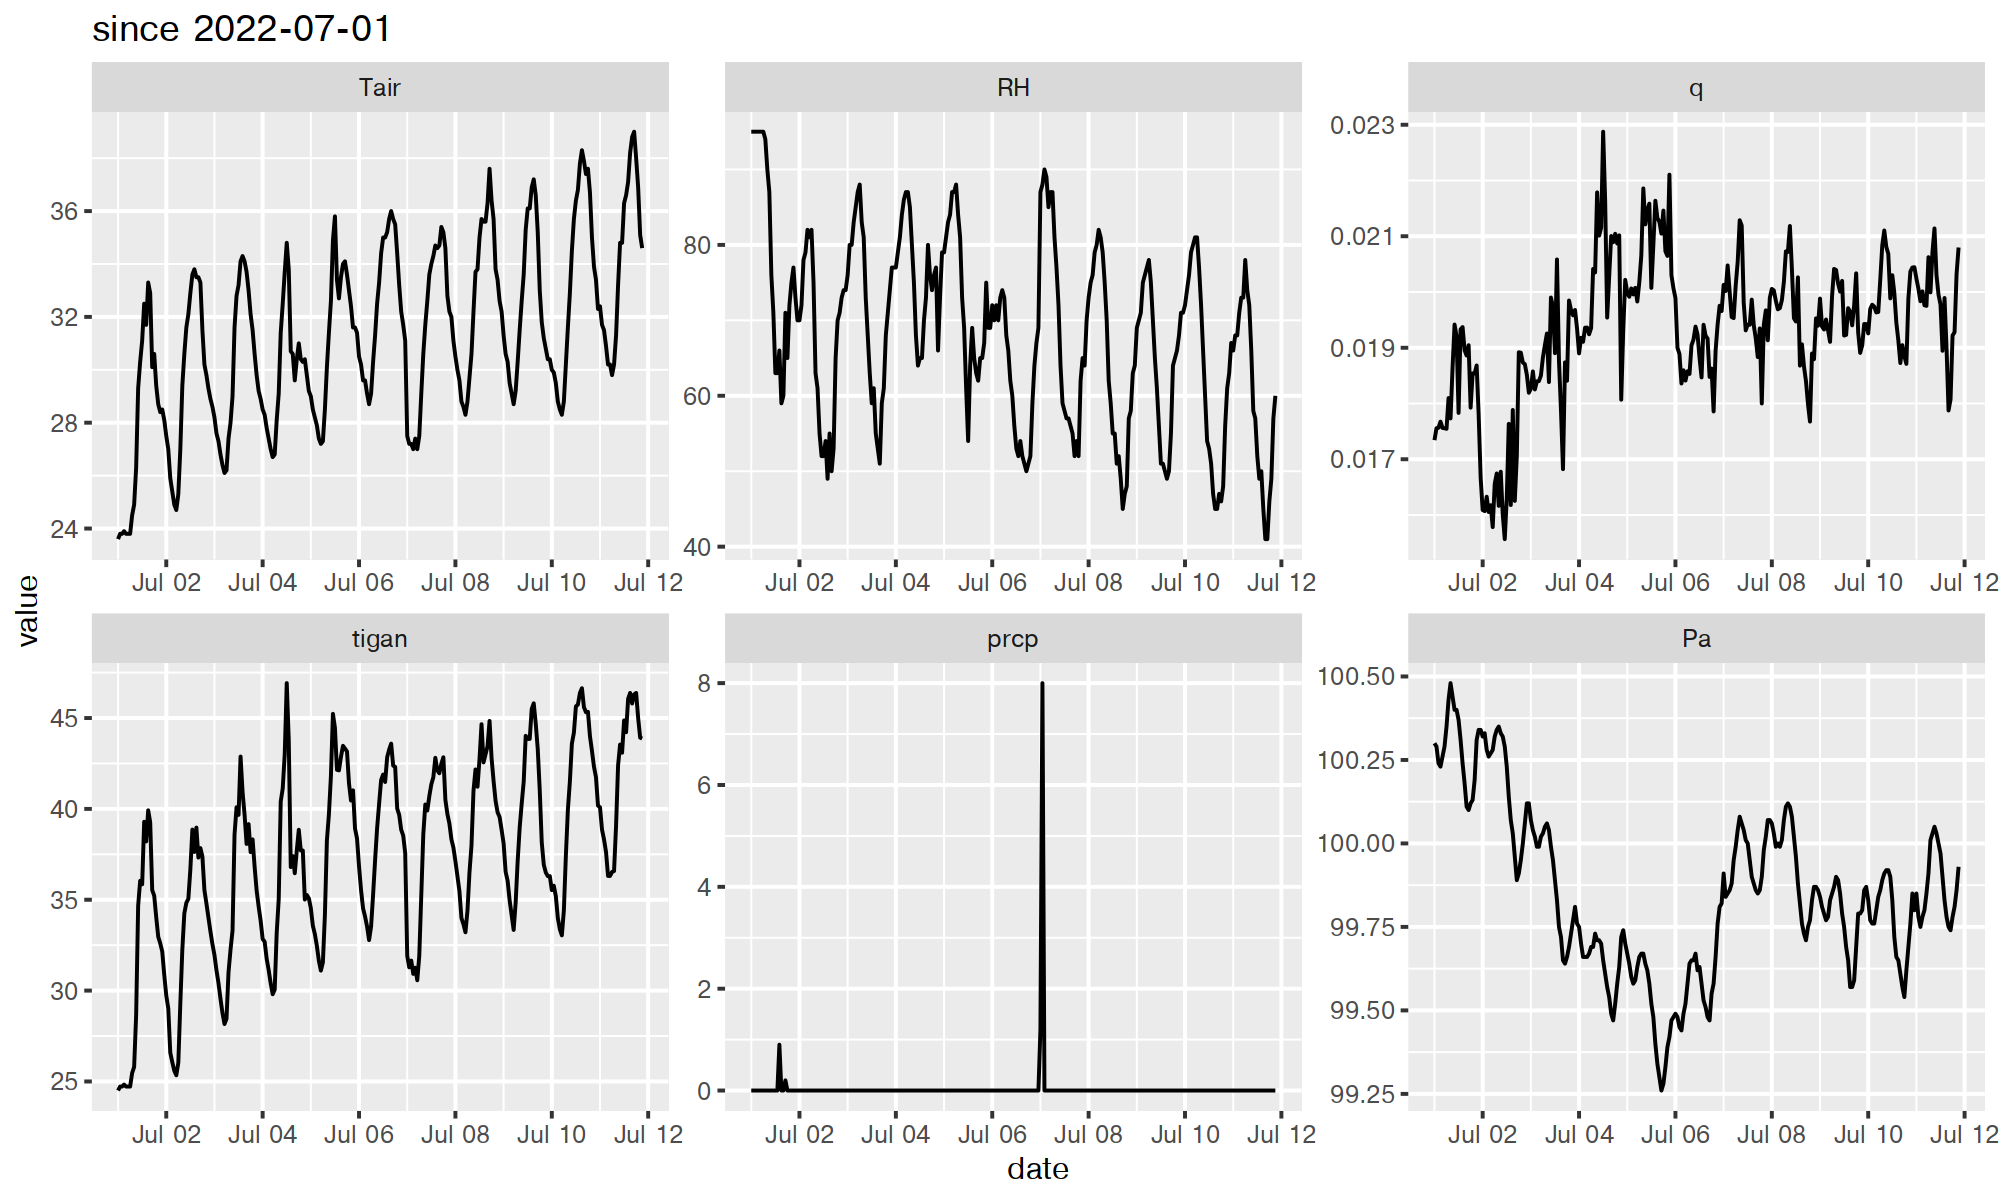

In [30]:
set_jupyter(10, 6, 200)

## 从6月份开始的数据
ggplot(dat[date >= make_date(2022, 06, 01)], aes(date, value)) +
  geom_line() +
  facet_wrap(~variable, scales = "free") + 
  ggtitle("since 2022-06-01")

## 7月份开始
ggplot(dat[date >= make_date(2022, 07, 01)], aes(date, value)) +
  geom_line() +
  facet_wrap(~variable, scales = "free") + 
  ggtitle("since 2022-07-01")


可以看到气温和体感温度一路单调线性飙升；RH在60%-80%之间波动，由于Tair上升，es变大，RH有所下降。 

### Further Questions:

1. 哪个时间段最热？
2. 气压和温度之间的关系？

hour,Tair,RH,q,tigan,prcp,Pa
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,29.00000,76.00000,0.01909450,33.92273,0.1090909,99.91727
1,28.61818,77.45455,0.01904352,33.21818,0.7272727,99.88273
2,28.24545,79.09091,0.01904127,32.52636,0.0000000,99.85364
3,27.81818,80.72727,0.01897734,31.78182,0.0000000,99.84818
4,27.49091,82.00000,0.01892166,31.21727,0.0000000,99.86455
5,27.24545,82.81818,0.01883706,30.76091,0.0000000,99.89909


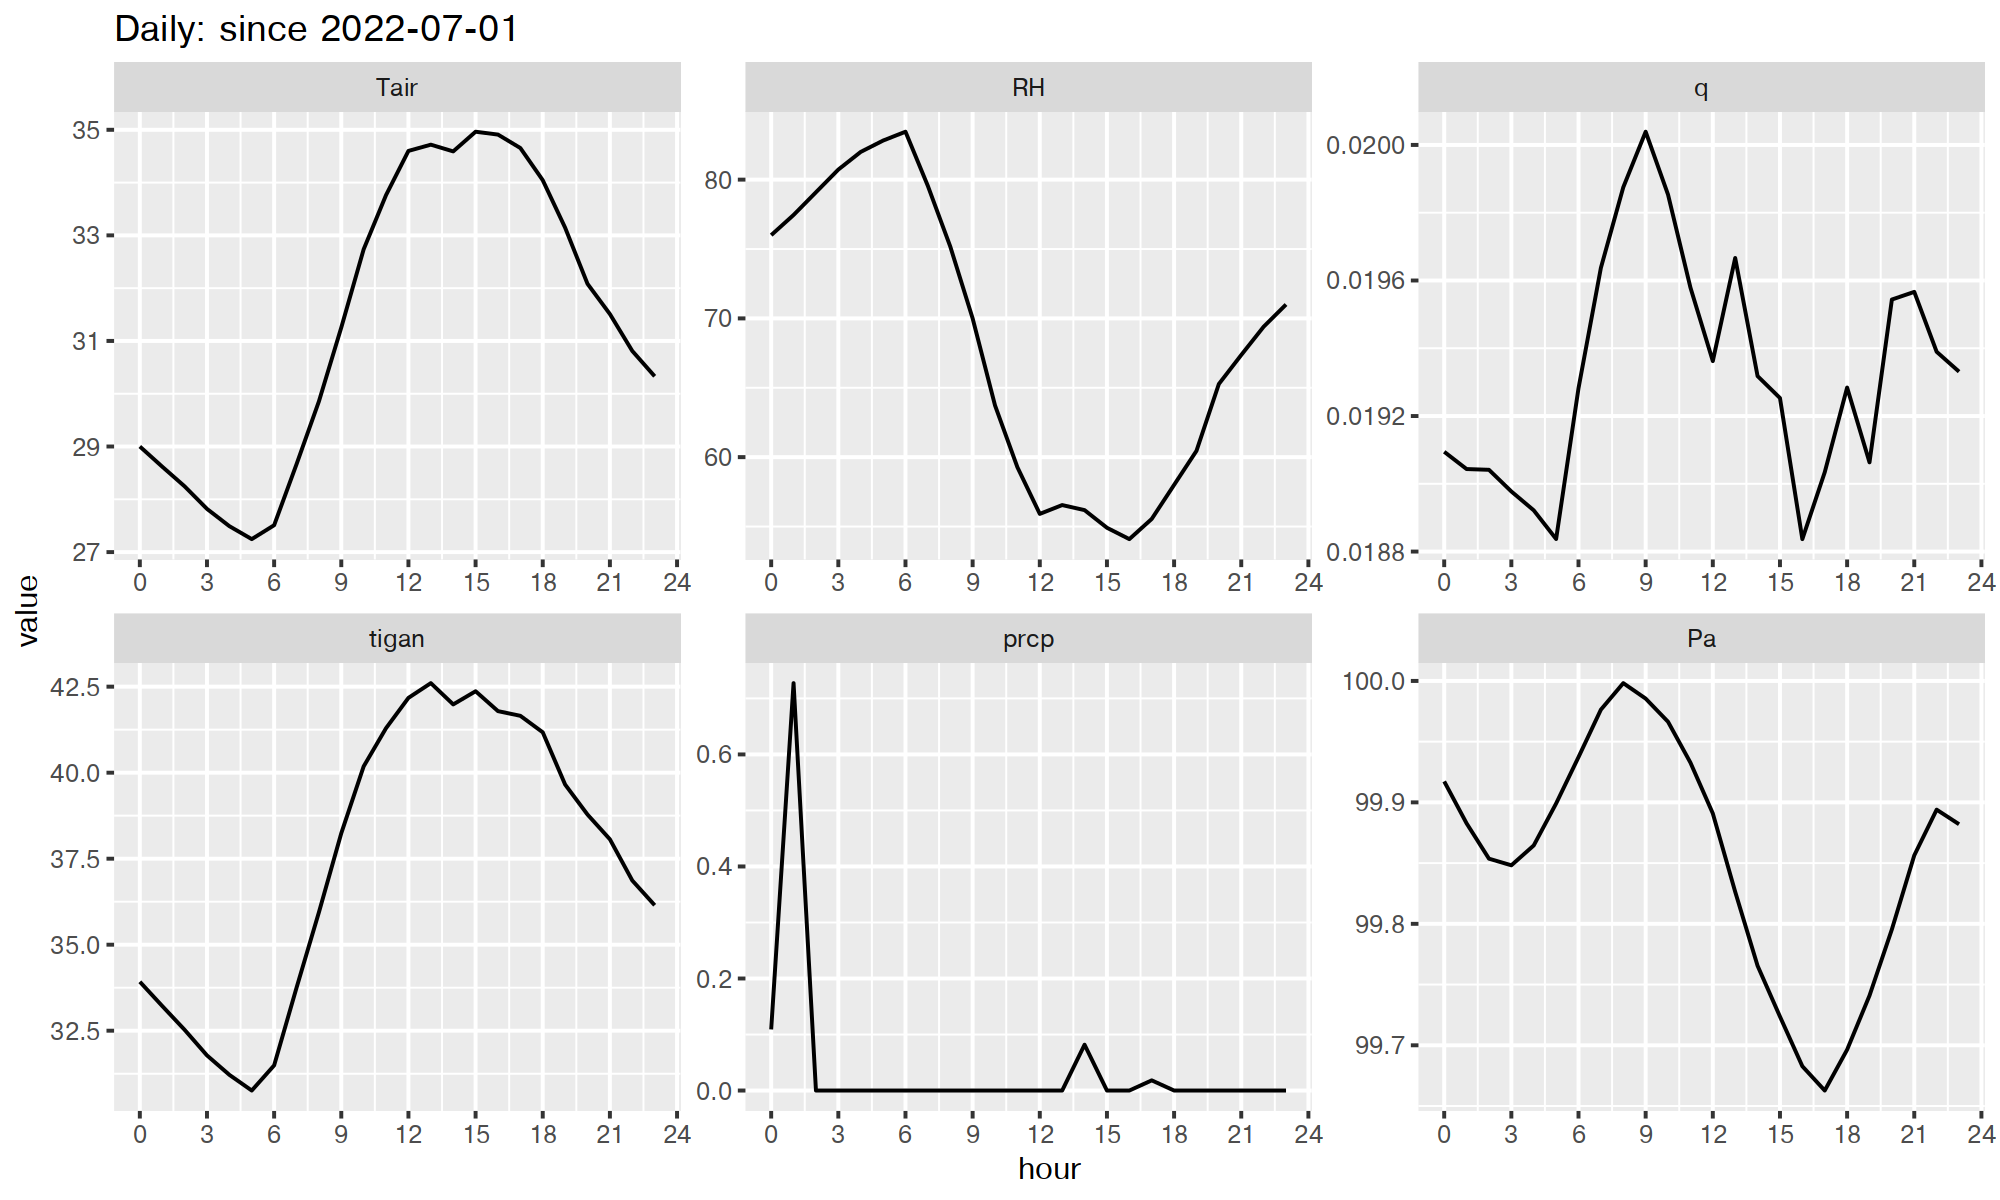

In [59]:
# head(d)
d_hour = d[date >= make_date(2022, 7), lapply(.SD, mean), .(hour(date)), .SDcols = colnames(d)[-1]]
head(d_hour)
dat = melt(d_hour, "hour")
ggplot(dat, aes(hour, value)) +
  geom_line() +
  facet_wrap(~variable, scales = "free") +
  ggtitle("Daily: since 2022-07-01") + 
  scale_x_continuous(breaks = seq(0, 24, 3))

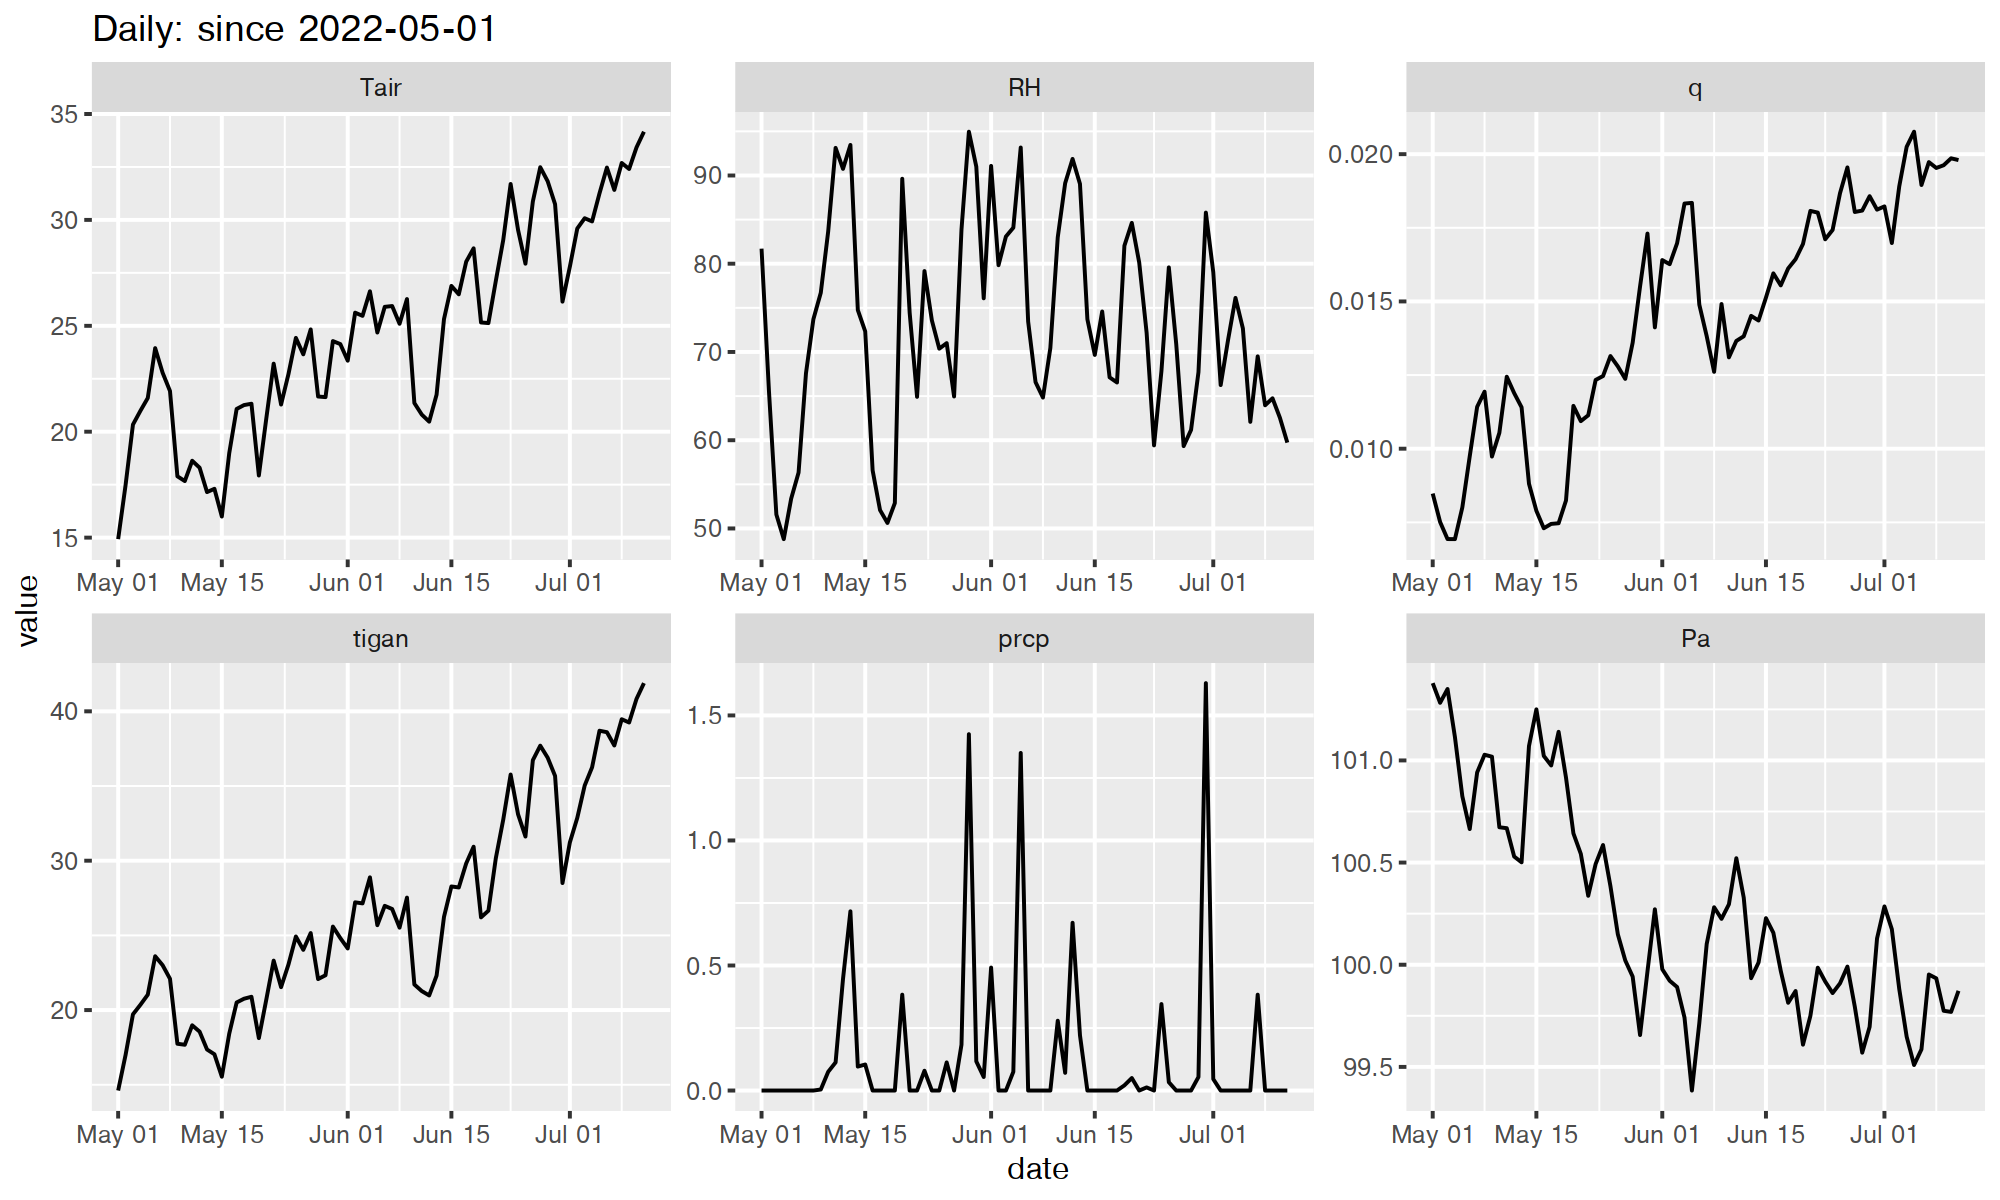

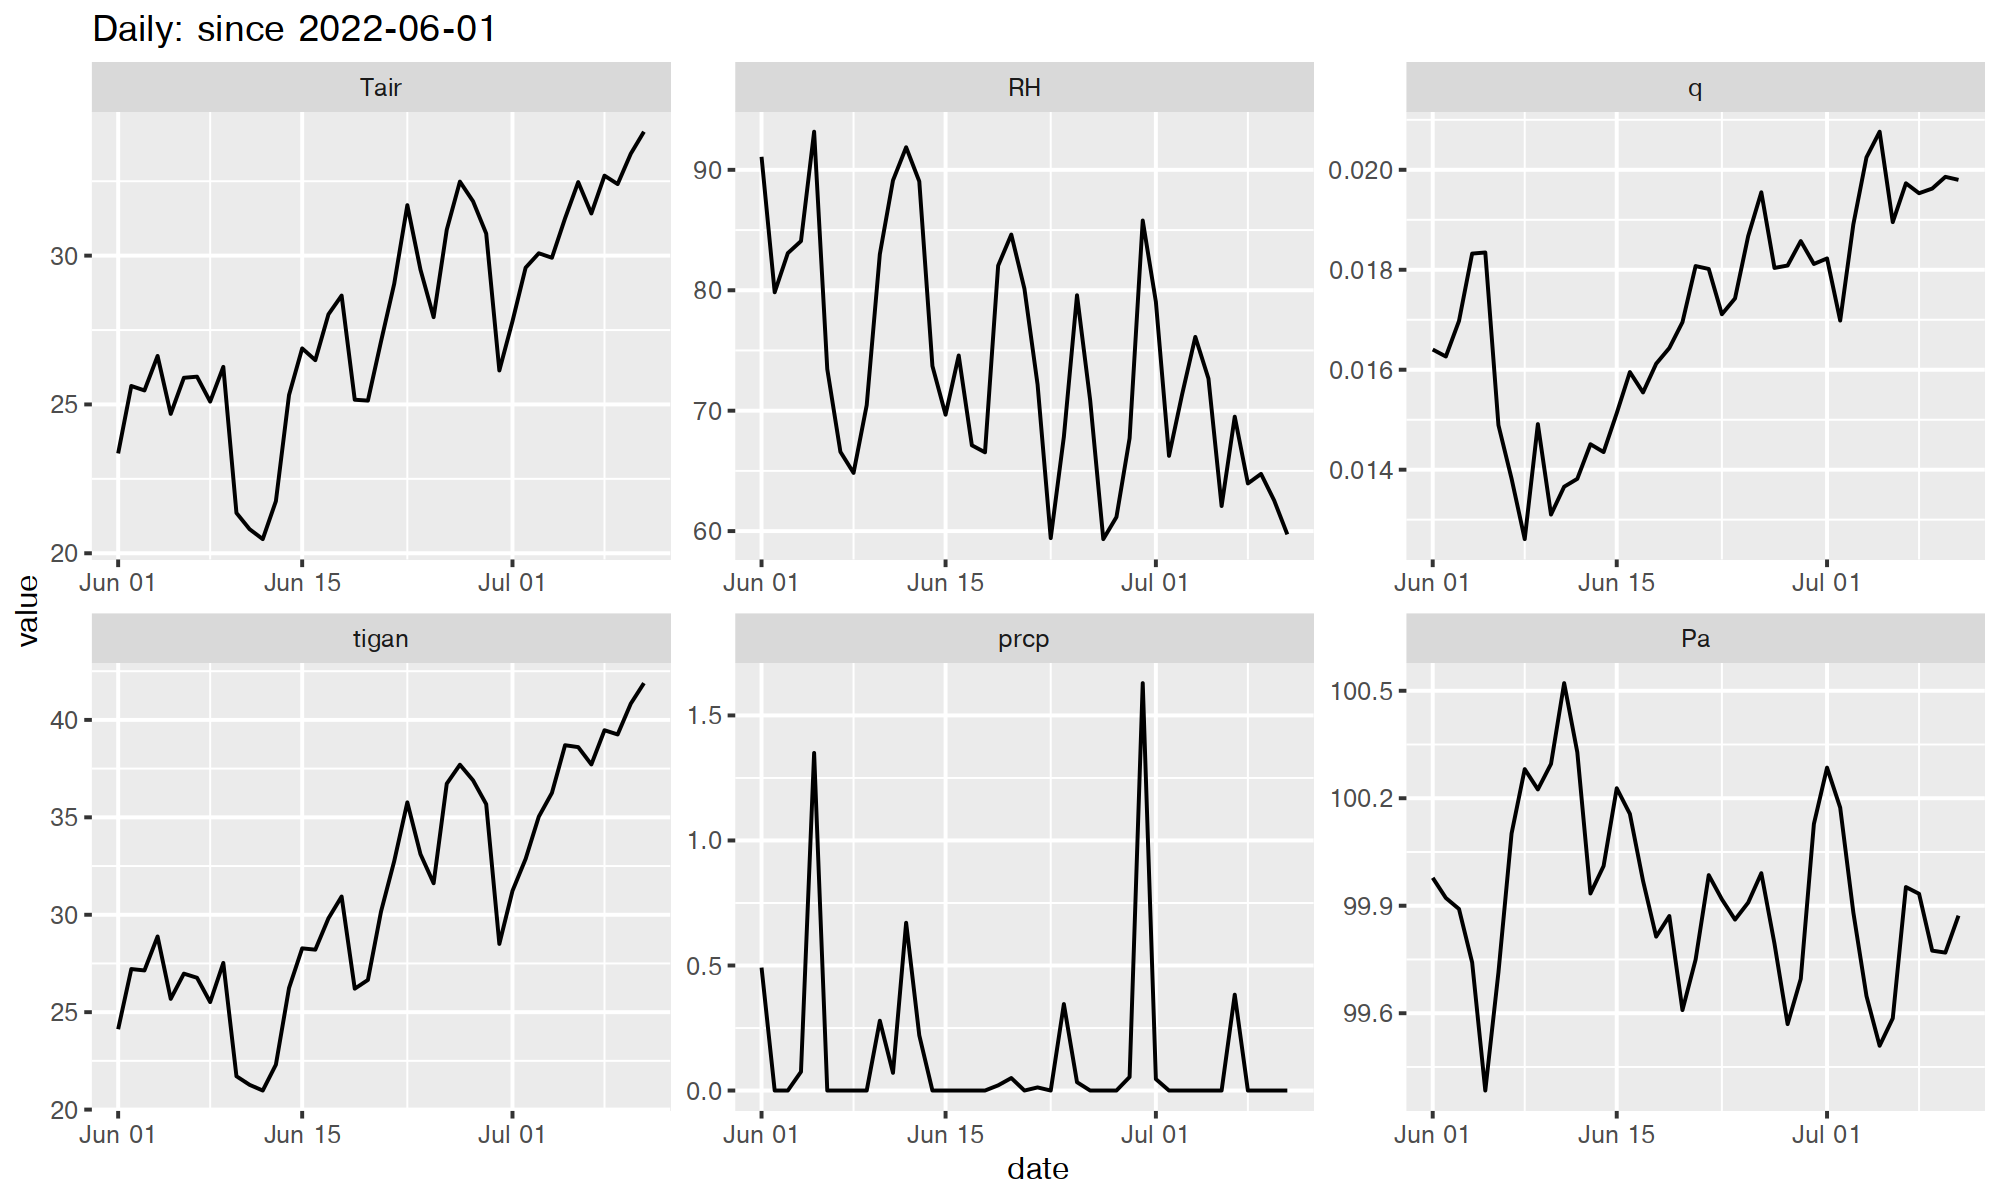

In [49]:
d_day <- d[, lapply(.SD, mean), .(date(date)), .SDcols = colnames(d)[-1]]
dat <- melt(d_day, "date")
ggplot(dat[date >= make_date(2022, 05, 01)], aes(date, value)) +
  geom_line() +
  facet_wrap(~variable, scales = "free") + 
  ggtitle("Daily: since 2022-05-01")

ggplot(dat[date >= make_date(2022, 06, 01)], aes(date, value)) +
  geom_line() +
  facet_wrap(~variable, scales = "free") + 
  ggtitle("Daily: since 2022-06-01")

# 降雨具有消q的作用；